# SailGP Data Analyst Challenge

The aim is to test you python abilities. The challenge is to analyze the data provided and answer the questions below. You can use any library you want to help you with the analysis. The data is from the SailGP event in Auckland 2025. The data is in the 'DATA' folder.

There are various sources available.

The Boat Logs are in the 'Boat_Logs' folder. The data is in csv format and the columns are described in the 'Boat_Logs/Boat_Logs_Columns.csv' file.
The 'Course_Marks_2025-01-19.csv' file contains the mark positions and wind reading on the course for the whole day.

The Race_XML folder contains the xml files for each race that contains information on where the boundaries of the course are, the theoretical position of the marks and the target racecourse axis.

The 2025-01-19_man_summary.csv file contains the metrics from the manoeuvre summary for the day.
The 2025-01-19_straight_lines.csv file contains the metrics from the straight line summary for the day.

Both are derived from the boat logs.

The 2502 m8_APW_HSB2_HSRW.kph.csv file contains the polar data for the boats in that config.

## Requierements
- Chose at least 3 questions from the list below to answer.
- Python 3.8 or higher
- Notebook should be able to run without any errors from start to finish.
- Specify the libraries (imports) used in the notebook.
- Any comments to make the notebook self-explanatory and easy to follow would be appreciated.
- If you can't get to the end of a question, we would appreciate the code you have written so far and explain what you were trying to do.

## Further information:
- We usually use bokeh for visualizations. So any showcase of bokeh would be appreciated.
-

## Submitting the results.
It would be great if you could provide a jupyter notebook with the code and the results of the analysis. You can submit the results by sharing a link to a git repository.


### Imports and re-used functions
Free section to initialize the notebook with the necessary imports and functions that will be used in the notebook.



In [20]:
%pip install -r requirements.txt -q


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from race_parser import Race
import os
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
import shap
from bokeh.layouts import gridplot
from bokeh.io import show, output_file

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates haversine dist
    """
    # convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371000  # Radius of Earth
    distance = c * r

    return distance

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate the bearing between two coordinate points.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))
    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    bearing = (initial_bearing + 360) % 360
    return bearing

def plot_race_coords(timeseries_df, column=None):
    """
    timseries_df: pandas dataframe containing boat logs
    column: column to color the markers by
    """
    source = ColumnDataSource(timeseries_df)

    col_min = timeseries_df[column].min()
    col_max = timeseries_df[column].max()
    mapper = LinearColorMapper(palette=Viridis256, low=col_min, high=col_max)
    
    # Create a figure
    p = figure(title="VMC Around the Course",
               x_axis_label='Longitude',
               y_axis_label='Latitude',
               tools="pan,wheel_zoom,reset,save")
    
    # Plot circles using the coordinates and color them according to vmc
    p.circle(x='LONGITUDE_GPS_unk', y='LATITUDE_GPS_unk',
             size=8,
             source=source,
             color=linear_cmap('vmc', Viridis256, col_min, col_max),
             fill_alpha=0.8)
    
    # Add a color bar to show the mapping from color to VMC values
    color_bar = ColorBar(color_mapper=mapper, label_standoff=12, location=(0,0), title="VMC (km/h)")
    p.add_layout(color_bar, 'right')
    
    # Specify output file (if you want to save it as an HTML file)
    output_file("vmc_course_visualization.html")
    
    # Display the plot
    show(p)

In [3]:
race1 = Race.from_xml("Data/Race_XMLs/25011905_03-13-55.xml")
race2 = Race.from_xml("Data/Race_XMLs/25011906_03-35-13.xml")
race3 = Race.from_xml("Data/Race_XMLs/25011907_03-56-34.xml")
race4 = Race.from_xml("Data/Race_XMLs/25011908_04-23-32.xml")

boat_data = {}
# Iterate over items in boat_logs folder and store dataframes in a dictionary
# The country code is used as the key
boat_files = os.listdir("Data/Boat_logs")
for file in boat_files:
    file_path = os.path.join("Data/Boat_logs", file)
    temp_df = pd.read_csv(file_path)
    temp_df['DATETIME'] = pd.to_datetime(temp_df['DATETIME'])
    temp_df['TIME_LOCAL_unk'] = pd.to_datetime(temp_df['TIME_LOCAL_unk'])
    country_code = file.split('_')[1].split('.')[0]
    boat_data[country_code] = temp_df

In [4]:
# Checking to see if the marks and boundary positions make sense.
race1.plot_course()
race2.plot_course()
race3.plot_course()
race4.plot_course()

The mark positions look correct for race 1, 2, 3, but it looks like the marks are out of position for race 4.

## Question 1: Write a Python function that can take a compass direction (ie. TWD or Heading) and calculate an accurate mean value across a downsampled frequency. Eg. If TWD is at 1Hz, give me a 10s average.

In [5]:
def downsampled_mean_direction(x, freq=10):
    """
    x: a pandas series
    freq: the number of indices for the rolling average
    Calculate the mean direction of a compass direction across a downsampled frequency.
    """
    # Convert to radians
    x = np.radians(x)
    # Downsample with rolling average
    x = x.rolling(freq).mean()
    downsampled_twd = np.degrees(x)
    return downsampled_twd

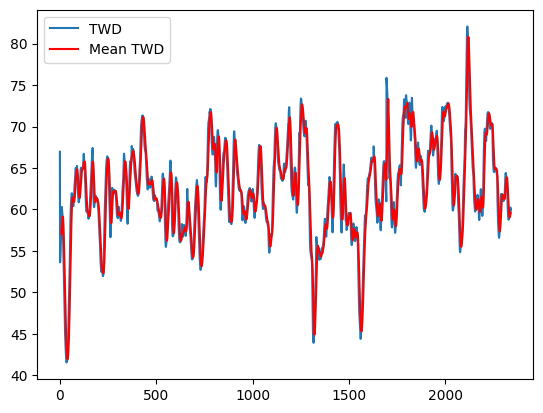

In [6]:
# Test the function
twd = boat_data['AUS']['TWD_SGP_deg']
downsampled_twd = downsampled_mean_direction(twd, freq=10)
plt.plot(twd, label='TWD')
plt.plot(downsampled_twd, color='r', label='Mean TWD')
plt.legend()
plt.show()

The function now calculates a 10s average of the TWD data.

## Question 2: Given a course XML and a timeseries of boat Lat/Lon values, calculate a VMC column for the same timeseries.


In [7]:

def calculate_vmc(course_xml, timeseries_df):
    race_data = Race.from_xml(course_xml) # Convert to a race object (race_parser.py) for ease of data retrieval
    
    # Assuming I can only use lat/lon values as stated in the question, I will need to calculate the boat's course over ground and speed first
    def add_cog_and_sog(df):
        """
        Adds cog and sog to the dataframe based solely on coordinates
        """
        df = df.copy()
        # Shift the latitude, longitude, and timestamp columns to get the next point in each row
        df['lat_next'] = df['LATITUDE_GPS_unk'].shift(-1)
        df['lon_next'] = df['LONGITUDE_GPS_unk'].shift(-1)
        df['time_next'] = df['DATETIME'].shift(-1)
    
        # Calculate the course over ground and distance for each row using haversine dist
        df['distance_m'] = df.apply(lambda row: haversine(row['LATITUDE_GPS_unk'], row['LONGITUDE_GPS_unk'], row['lat_next'], row['lon_next']), axis=1)
        df['cog'] = df.apply(lambda row: calculate_bearing(row['LATITUDE_GPS_unk'], row['LONGITUDE_GPS_unk'], row['lat_next'], row['lon_next']), axis=1)
    
        # Calculate the time difference in seconds
        df['time_diff_s'] = (df['time_next'] - df['DATETIME']).dt.total_seconds()
    
        # Calculate the speed over ground in meters per second
        df['sog_ms'] = df['distance_m'] / df['time_diff_s']
    
        # Clean up by dropping the temporary columns
        df.drop(['lat_next', 'lon_next', 'time_next', 'distance_m', 'time_diff_s'], axis=1, inplace=True)
    
        return df
    
    timeseries_df = add_cog_and_sog(timeseries_df) # Add cog and sog to df
    
    # Now, let's iterate over all the marks in the course by their sequence.
    # The overall idea is to detect roundings for each compound mark, which will then allow for comparing the current target mark with the boat's position.
    cur_idx = 0 # Current index in the timeseries data, will be updated when the boat rounds a mark
    timeseries_df['rounded'] = 0 # Column to store the mark ID when the boat rounds a mark
    
    for compound_event in race_data.compound_mark_sequence:
        cm_id = compound_event.get('CompoundMarkID')
        # Get the compound mark data
        compound = race_data.compound_marks.get(cm_id)
        
        cur_df = timeseries_df.loc[cur_idx:].copy() # Set the start index to the latest rounding index
        
        marks = compound.get("Marks", [])
        mark_lats = [float(m["TargetLat"]) for m in marks] # Get the coords of the next mark (gates)
        mark_lngs = [float(m["TargetLng"]) for m in marks]
        target_lat = np.mean(mark_lats) # Set this as the target coords
        target_lng = np.mean(mark_lngs)
        
        # Calculate the course to the mark
        cur_df['course_to_mark'] = cur_df.apply(lambda row: calculate_bearing(row['LATITUDE_GPS_unk'], row['LONGITUDE_GPS_unk'], target_lat, target_lng), axis=1)
        # Calculate the VMC in km/h since the rest of the data uses it
        timeseries_df.loc[cur_idx:, 'vmc'] = cur_df['sog_ms'] * np.cos(np.radians(cur_df['cog'] - cur_df['course_to_mark'])) * 3.6
        
        # Find the index where the boat rounds the compound mark, check utils for the function
        rounding_idx = u.detect_rounding_for_compound(cur_df, compound, race_data.compound_marks['CourseAxis'])
        # Mark the rounding event in the DataFrame.
        timeseries_df.loc[rounding_idx, 'rounded'] = int(cm_id)
        cur_idx = rounding_idx
    
    return timeseries_df
        
    
xml_file = 'Data/Race_XMLs/25011905_03-13-55.xml' # Course data for race 1

race_num = 0 # Picking the first race id
aus_df = boat_data['AUS']
race_nums = aus_df['TRK_RACE_NUM_unk'].unique()
aus_df = aus_df[aus_df['TRK_RACE_NUM_unk'] == race_nums[race_num]]

aus_df_vmc = calculate_vmc(xml_file, aus_df)

# Visualize the VMC to verify the data
plot_race_coords(aus_df_vmc, column='vmc')

Overall, the VMC calculation looks correct. When following the boat data from start to finish, the VMC values seem to be in line with the course and the boat's speed and heading. The trickiest part was identifying the mark roundings correctly, but the function seems to be working as intended, although it could be improved further with more work.

## Question 3: Verify and comment on the boats calibration. If possible propose a post-calibrated set of wind numbers and a potential calibration table.


There are two potential approaches here:
- Under the assumption that the wind data from the course marks is calibrated and more reliable than the boat data, we can find all the points where the boat is within a certain distance of a course mark and compare the wind data from the course mark to the boat's wind data.
- We can also compare wind data between the boats to identify certain boats that are consistently higher or lower than the others. My suggested approach here is to iterate over each boat, and identify all points in the session where they are within x distance of another boat. When they are within this distance, I would compare the wind data between the two boats and the differences in wind readings. Then, I will inspect the distribution of these differences to identify any consistent biases. If some boats are found to be close, with a few outliers, we can adjust the wind data for the outliers to match the close boats and create a calibration table based on this.

## Question 4: Given a timeseries of Lat/Lon positions and a course XML, in a Python notebook, calculate a Distance to Leader metric for each boat.

My approach will be to:
- Iterate over each boat in the timeseries data
- Iterate over each compound mark in the course XML
- For each leg in the race, calculate the position of the boat projected onto the line between the previous mark and the current mark. This will give us the VMC distance sailed on the current leg.
- When a boat completes a leg, add it to a total distance sum.
- To calculate the total VMC distance completed, add the current leg progress to the total distance at each point in time.
- Then, when all this data is calculated for all the boats, subtract the max VMC distance completed at each point in the race from all the boats, to get the distance to the leader. Naturally, this will result in a DTL of 0 for the leader.

None


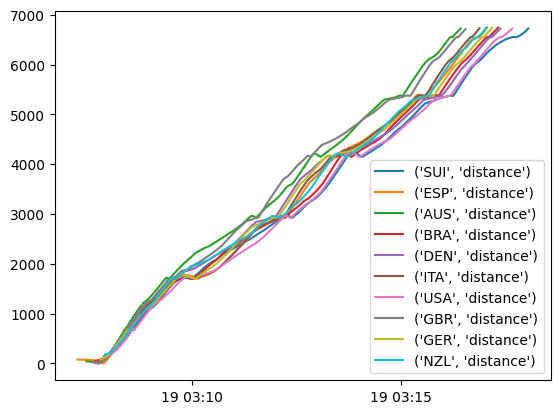

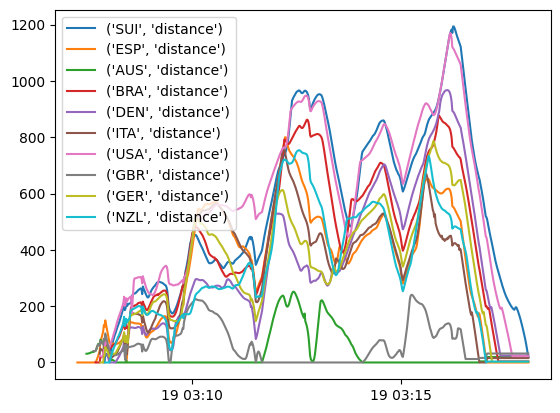

,SUI,ESP,AUS,BRA,DEN,ITA,USA,GBR,GER,NZL
,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance
DATETIME,,,,,,,,,,
2025-01-19 02:56:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-19 02:56:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-19 02:56:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-19 02:59:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-19 03:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-01-19 03:17:59,77.162438,0.0,19.489791,3.749075,24.627507,15.660197,22.66151,31.831382,2.137938,3.187112
2025-01-19 03:18:00,64.104375,0.0,19.489791,3.749075,24.627507,15.660197,22.66151,31.831382,2.137938,3.187112


In [17]:
def calculate_distance_to_leader(course_xml, boat_data_dict):
    """
    Calculates the distance to leader for each boat
    :param course_xml: path to the xml file of the race
    :param boat_data_dict: dictionary containing the boat data
    :return: dataframe containing the distance to leader for the race
    """
    race_data = Race.from_xml(course_xml) # Convert to race object
    total_distance_data = {}
    for key, data in boat_data_dict.items():
        data = data.copy()
        try:
            # Here, we will use a similar logic to the vmc calculations to detect when a boat has completed a leg by rounding a target mark
            cur_idx = 0
            total_dist = 0
            prev_mark = None # Variable to store the previous mark's coords
            for compound_event in race_data.compound_mark_sequence:
                cm_id = compound_event.get('CompoundMarkID')
                # Get the compound mark data
                compound = race_data.compound_marks.get(cm_id)
                
                cur_df = data.copy()[cur_idx:]
                
                marks = compound.get("Marks", [])
                mark_lats = [float(m["TargetLat"]) for m in marks]
                mark_lngs = [float(m["TargetLng"]) for m in marks]
                target_lat = np.mean(mark_lats)
                target_lng = np.mean(mark_lngs)
                
                # If there is a previous mark (the boat has started the race), calculate the distance to the previous mark, along the unit vector between the two marks
                if prev_mark is not None:
                    # Project the position on the unit vector between the two marks
                    cur_df['projected_pos'] = cur_df.apply(lambda row: u.project_point_between_marks(prev_mark, (target_lat, target_lng), (row['LATITUDE_GPS_unk'], row['LONGITUDE_GPS_unk'])), axis=1)
                    
                    # Calculate the distance between each projected position using haversine
                    cur_df['distance'] = cur_df['projected_pos'].apply(lambda x: haversine(x[0], x[1], prev_mark[0], prev_mark[1]))
                    
                    # Add the distance to the total distance
                    cur_df['distance'] = cur_df['distance'] + total_dist
                    
                    # Add distance data to timeseries df
                    data.loc[cur_idx:, 'distance'] = cur_df['distance']
                    
                    # Calculate the total distance of the leg and add to total
                    leg_dist = haversine(prev_mark[0], prev_mark[1], target_lat, target_lng)
                    total_dist += leg_dist
                
                
                # Find the index where the boat rounds this compound mark.
                rounding_idx = u.detect_rounding_for_compound(cur_df, compound, race_data.compound_marks['CourseAxis'])
                # Mark the rounding event in your DataFrame.
                data.loc[rounding_idx, 'rounded'] = cm_id
                cur_idx = rounding_idx
                prev_mark = (target_lat, target_lng)
            data.set_index('DATETIME', inplace=True) # Set the datetime as index to join by time
            total_distance_data[key] = data[:cur_idx][['distance']]
        except Exception as e:
            print(e)
            continue
        
    # Now, combine the total distance data for each boat and plot
    total_distance_df = pd.concat(total_distance_data, axis=1)
    plt.plot(total_distance_df, label=total_distance_df.columns)
    plt.legend()
    plt.show()
    
    total_distance_df = total_distance_df.ffill() # We use forward fill here to ensure that when the boats cross the finish line, the boats that have not finished will be compared to the total distance at finish
    
    # Calculate the distance to leader
    # For each row, find the maximum distance and subtract this distance for all the boats
    for idx, row in total_distance_df.iterrows():
        max_dist = row.max()
        total_distance_df.loc[idx] = max_dist - row
    plt.plot(total_distance_df, label=total_distance_df.columns)
    plt.legend()
    plt.show()
    
    return total_distance_df
    
calculate_distance_to_leader(xml_file, boat_data)

Note that before they have crossed the starting line, all boats will have NaN values for the distance to the leader. The calculated distance to leader data matches what we saw in the race, with AUS winning, followed by GBR and ITA.

## Question 5: Given a course XML, along with a wind speed and direction and a polar, calculate the minimum number of tacks or gybes for each leg of the course and each gate mark on the leg.

My approach will be to simulate different possibilities for each leg, by testing combinations of both top marks and both bottom marks. I will maximize VMG for upw and dw legs, and skip reaching legs for the calculations. I will force the model to make a tack or gybe whenever it hits a boundary or layline. This model makes a few assumptions:
- It does not account for displacement during maneuvers, it simulates an instant tack. However, this will still be accurate in the majority of cases.
- It assumes that boats will maximize VMG
- It assumes that the boats will minimize tacks by going all the way to the boundaries. However, for some different course limits or obstacles (e.g. shark island), this may not always be the best strategy to minimize maneuvers. 

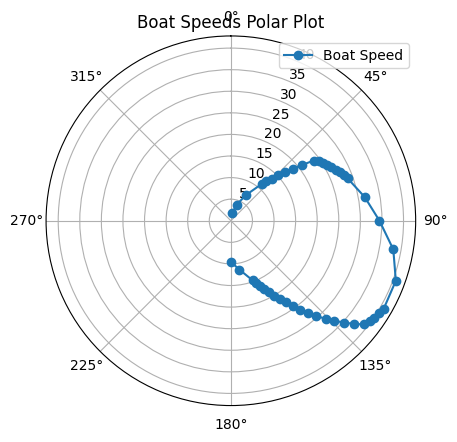

Skipping leg 1
Skipping leg 2
Minimum maneuvers for leg 3: 1


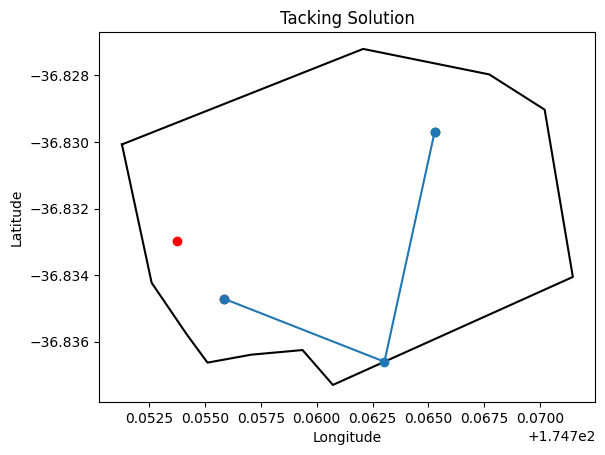

Minimum maneuvers for leg 4: 2


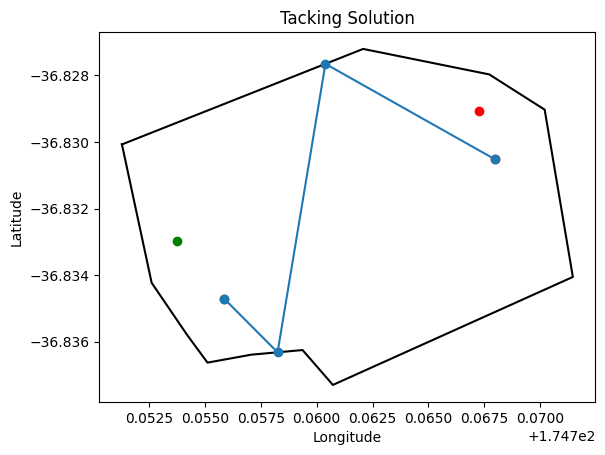

Minimum maneuvers for leg 5: 2


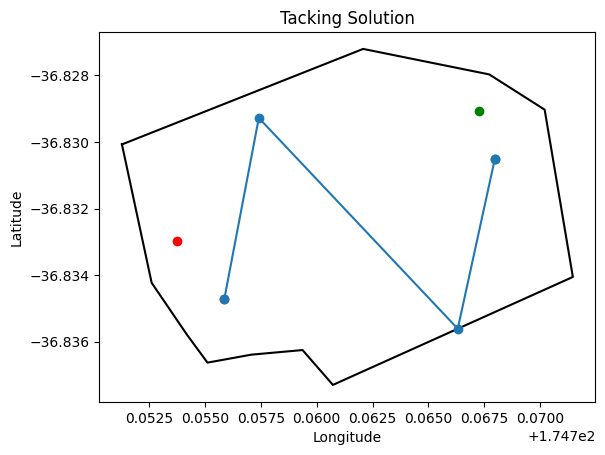

Minimum maneuvers for leg 6: 2


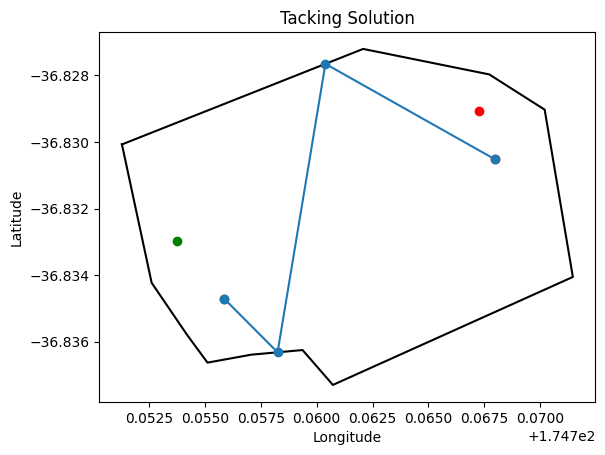

Minimum maneuvers for leg 7: 2


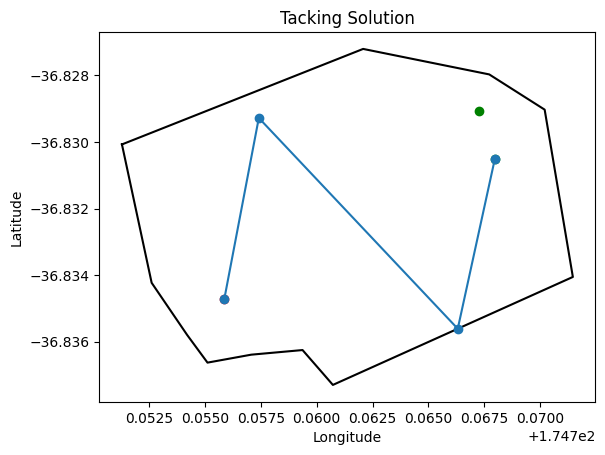

Skipping leg 8


,leg_id,maneuvers
3,3,1
4,4,2
5,5,2
6,6,2
7,7,2


In [9]:
def calculate_minimum_maneuvers(course_xml, wind_speed, wind_direction, polar_file):
    """
    A function to calculate the minimum number of maneuvers for each leg in the course, using polars
    :param course_xml: a file path to the course xml
    :param wind_speed: a given wind speed, the function will find the closest point on the polar
    :param wind_direction: 
    :param polar_file: 
    :return: 
    """
    polar = pd.read_csv(polar_file)
    wind_speed_cols = [col for col in polar.columns if col != 'TWA/TWS']
    wind_speed_nums = {}
    for col in wind_speed_cols:
        wind_speed_nums[col] = float(col)
    closest_col = min(wind_speed_nums, key=lambda col: abs(wind_speed_nums[col] - wind_speed))
    polar = polar[['TWA/TWS', str(closest_col)]]
    # Check the polars
    u.create_polar_plot(polar, angle_col='TWA/TWS', speed_col=str(closest_col)) # Plot the polar just to get an idea of how it looks
    # Calculate VMG
    polar['VMG'] = polar[str(closest_col)] * np.cos(np.radians(polar['TWA/TWS']))# Calculate VMG
    polar['VMG'] = polar[str(closest_col)] * np.cos(np.radians(polar['TWA/TWS']))
    
    
    race_data = Race.from_xml(course_xml)

    prev_mark = None

    boundary = race_data.course_limits["Boundary"] # Get the boundary limits
    poly_x = []
    poly_y = []
    # Extract the boundary points
    for limit in boundary.get("Limits", []):
        try:
            poly_x.append(float(limit.get("Lat", 0)))
            poly_y.append(float(limit.get("Lon", 0)))
        except (TypeError, ValueError):
            continue
            
    boundary_points = np.array([poly_x, poly_y]).T
    
    min_maneuver_data = {} # Store the minimum maneuver data for each leg
    
    # Iterate over each leg
    for compound_event in race_data.compound_mark_sequence:
            cm_id = compound_event.get('CompoundMarkID')
            # Get the compound mark data
            compound = race_data.compound_marks.get(cm_id)
            
            compound_name = compound.get('Name', '')
            
            marks = compound.get("Marks", [])
            
            if compound_name.startswith('WG'):
                max_vmg_idx = polar['VMG'].idxmax()
            elif compound_name.startswith('LG'):
                max_vmg_idx = polar['VMG'].idxmin()
            else:
                print(f"Skipping leg {cm_id}")
                prev_mark = marks
                continue
            
            min_maneuver_path = [] # The path with the minimum number of maneuvers
            min_maneuvers = np.inf # The minimum number of maneuvers
            
            # Check if there is a previous mark (race started)
            if prev_mark is not None:
                for start_mark in prev_mark:
                    start_coords = (start_mark['TargetLat'], start_mark['TargetLng'])
                    
                    max_vmg_twa = polar.loc[max_vmg_idx, 'TWA/TWS']
                    
                    # The start tack will determine if the boat starts on port/starboard
                    mark_name = start_mark['Name']
                    if mark_name.endswith('1'):
                        start_tack = 1
                    elif mark_name.endswith('2'):
                        start_tack = 2
                    
                    for target_mark in marks:
                        target_coords = (target_mark['TargetLat'], target_mark['TargetLng'])
                        path, total_maneuvers = u.simulate_path_to_layline(start_coords, target_coords, wind_direction, max_vmg_twa, boundary_points, first_tack=start_tack)
                        # If the path results in less tacks than the current minimum, store it
                        if total_maneuvers < min_maneuvers:
                            min_maneuvers = total_maneuvers
                            min_maneuver_path = path
                
                if min_maneuvers == np.inf:
                    print(f"No maneuvers needed for leg {cm_id}")
                else:
                    print(f"Minimum maneuvers for leg {cm_id}: {min_maneuvers}")
                    u.plot_solution(boundary_points, min_maneuver_path, 'Minimum Maneuver Path', prev_mark, marks)
                    
                min_maneuver_data[cm_id] = {'leg_id': cm_id, 'maneuvers': min_maneuvers}
                    
                prev_mark = marks
            else:
                prev_mark = marks
    
    return min_maneuver_data
    

xml_file = 'Data/Race_XMLs/25011905_03-13-55.xml'
min_maneuver_data = calculate_minimum_maneuvers(xml_file, 12, 70, 'Data/2502 m8_APW_HSB2_HSRW.kph.csv')

min_maneuver_df = pd.DataFrame(min_maneuver_data).T
min_maneuver_df





## Question 6: Calculate a “tacked” set of variables depending on the tack of the boat, so that sailors don’t need to think about what tack they’re on when looking at measurements. And show the results in a visualisation.


In [10]:
# Using AUS as an example
aus_df = boat_data['AUS'] 
race_nums = aus_df['TRK_RACE_NUM_unk'].unique()
race_num = 0
# Getting just the data from race 1
race_df = aus_df[aus_df['TRK_RACE_NUM_unk'] == race_nums[race_num]].copy()
race_df['tack'] = np.where(race_df['TWA_SGP_deg'] < 0, 'starboard', 'port') # Starboard if TWA is negative, port if positive
race_df['upwind'] = np.abs(race_df['TWA_SGP_deg']) < 75 # Upwind if abs TWA is less than 80 degrees

upwind_df = race_df[race_df['upwind']] # Let's just look at upwind to evaluate

numeric_cols = upwind_df.select_dtypes(include=['number']).columns.tolist()

print("These data points have opposite signs on different tacks:")
for col in numeric_cols:
    group_medians = upwind_df.groupby('tack')[col].median() # using median, since mean can be affected by outliers
    if group_medians.iloc[0] * group_medians.iloc[1] < 0:
        print(col)

These data points have opposite signs on different tacks:
TWA_SGP_deg
AWA_SGP_deg
RATE_YAW_deg_s_1
LEEWAY_deg
ANGLE_CA1_deg
ANGLE_CA2_deg
ANGLE_CA4_deg
ANGLE_CA5_deg
ANGLE_CA6_deg
ANGLE_WING_TWIST_deg
ANGLE_WING_ROT_deg
ANGLE_DB_CANT_P_deg
ANGLE_DB_CANT_S_deg


- Let's pick the ones that make sense:
- All the wing data should be tacked, they seem to be consistently opposite signs between tacks, which makes sense
- TWA, AWA, and leeway can also be tacked
- I will not be including YAW, since after inspecting the data, it seems to be more independent from tack
- Even though it's not in the columns above, heel should be tacked, since instead of meaning starboard or port heel, this would mean leeward/windward heel by the sign. Which is more intuitive to the sailor.
- I will not tack the DB cant data in this case, since only one board is down the majority of the time.

In [11]:
tacked_cols = ['TWA_SGP_deg', 'AWA_SGP_deg', 'LEEWAY_deg', 'ANGLE_CA1_deg', 'ANGLE_CA2_deg', 'ANGLE_CA4_deg', 'ANGLE_CA5_deg', 'ANGLE_CA6_deg', 'ANGLE_WING_TWIST_deg', 'ANGLE_WING_ROT_deg', 'HEEL_deg']

for col in tacked_cols:
    race_df.loc[race_df['tack'] == 'starboard', col] *= -1

In [12]:


plots = []
tack_colors = {"port": "red", "starboard": "green"}

tack_labels = race_df['tack'].unique()

for col in tacked_cols:
    p = figure(title=f"Distribution of {col} by Tack",
               x_axis_label=col, y_axis_label="Count",
               toolbar_location=None, tools="", outer_width=250, outer_height=200)
    
    for tack in tack_labels:
        data = race_df[(race_df['upwind']) & (race_df['tack'] == tack)][col].dropna()
        hist, edges = np.histogram(data, bins=20)
        
        source = ColumnDataSource(data=dict(
            top=hist,
            left=edges[:-1],
            right=edges[1:]
        ))
        
        p.quad(top='top', bottom=0, left='left', right='right', 
               source=source,
               fill_color=tack_colors.get(tack, "gray"),
               fill_alpha=0.5,
               legend_label=str(tack))
    
    p.legend.location = "top_right"
    plots.append(p)

grid = gridplot(plots, ncols=2)
show(grid)

When examining the visualizations, it is now clear that the variables have been tacked correctly, as the distributions are consistent between the two tacks. This will make it easier for sailors to interpret the data without having to worry about which tack they are on. For the data, the sailors will now need to think about the values as in the direction of leeward/windward instead of port/starboard.

## Question 7: Given a set of tacks (in CSV), and train a model to explain the key features of these tacks when optimizing for vmg. Show appropriate visualisations to explain your conclusions.

- For this, I will use a fairly simple XGBoost model, which I have seen success with in the past for similar tasks.
- My main reason for choosing XGBoost is because it is more interpretable than a neural network, and can handle the non-linear relationships between the features and the target variable.

In [18]:
man_data = pd.read_csv('Data/2025-01-19_man_summary.csv')

man_data = man_data[man_data['type'] == 'tack']

# Inspect the data
print(man_data.describe())
print(man_data.head())

numeric_cols = man_data.select_dtypes(include=['number']).columns.tolist()

# Instead of splitting the data into port-stbd and stbd-port, I want to "tack" the data so that the features are consistent between the two tacks.
for col in numeric_cols:
    group_means = man_data.groupby('entry_tack')[col].median()
    if group_means.iloc[0] * group_means.iloc[1] < 0:
        print(col)
        
# From the above, I can see that the following columns have opposite signs between the two tacks:
# orig_entry_twa, orig_exit_twa, b_diff_1, and b_diff_2
# I will tack these columns
tacked_cols = ['orig_entry_twa', 'orig_exit_twa', 'b_diff_1', 'b_diff_2']
for col in tacked_cols:
    man_data.loc[man_data['entry_tack'] == 'stbd', col] *= -1

       WING_CONFIG_unk  MD4_SEL_DB_unk  MD4_SEL_RUD_unk        race  \
count            196.0           196.0            196.0  196.000000   
mean              11.0             3.0              2.0    5.867347   
std                0.0             0.0              0.0    0.972839   
min               11.0             3.0              2.0    5.000000   
25%               11.0             3.0              2.0    5.000000   
50%               11.0             3.0              2.0    6.000000   
75%               11.0             3.0              2.0    7.000000   
max               11.0             3.0              2.0    8.000000   

              leg   entry_bsp    exit_bsp     min_bsp    bsp_loss   entry_twa  \
count  196.000000  196.000000  196.000000  196.000000  196.000000  196.000000   
mean     2.545918   53.834745   43.642704   30.797959   23.036786   50.960204   
std      2.129869    7.947447   12.953027   10.666716    9.359715   12.786353   
min      0.000000   31.190000    9.4

In [14]:
X = man_data.drop(columns=['vmg_distance', 'BOAT', 'HULL', 'WING_CONFIG_unk', 'MD4_SEL_DB_unk', 'MD4_SEL_RUD_unk', 'DATETIME', 'TIME_LOCAL_unk', 'race', 'leg', 'dashboard', 'type', 'entry_tack', 'distance', 'dist_2', 'loss_vs_targ_vmg', 'theoretical_vmg', 'theoretical_distance', 'loss_vs_vmg', 'min_bsp'])
# Drop all equipment columns, meta data columns and target variable. I will also drop 'distance' and dist_2 because it is closely correlated to vmg_distance and would be a data leak.

y = man_data['vmg_distance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Create the initial XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define a parameter grid for hyperparameter tuning.
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE:", np.sqrt(-grid_search.best_score_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nicolaijacobsen/Desktop/SGP_Data_Challenge/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/nicolaijacobsen/Desktop/SGP_Data_Challenge/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/nicolaijacobsen/Desktop/SGP_Data_Challenge/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV RMSE: 33.8323660085795


Test RMSE: 34.249
Test MAE: 25.910
Test R2: 0.746


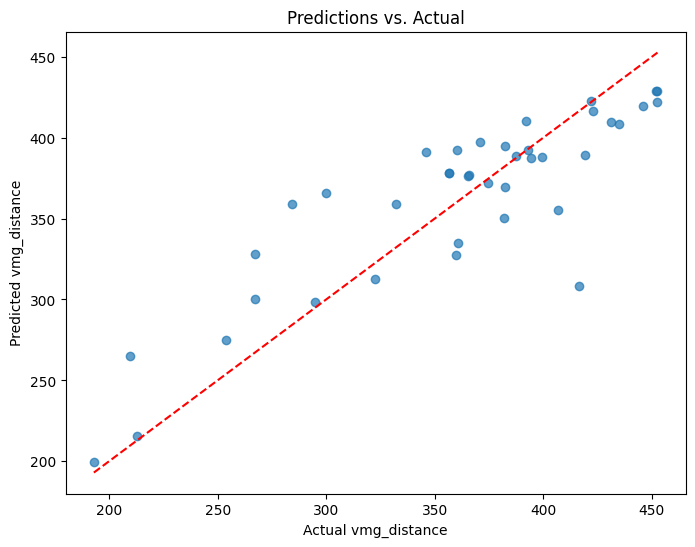

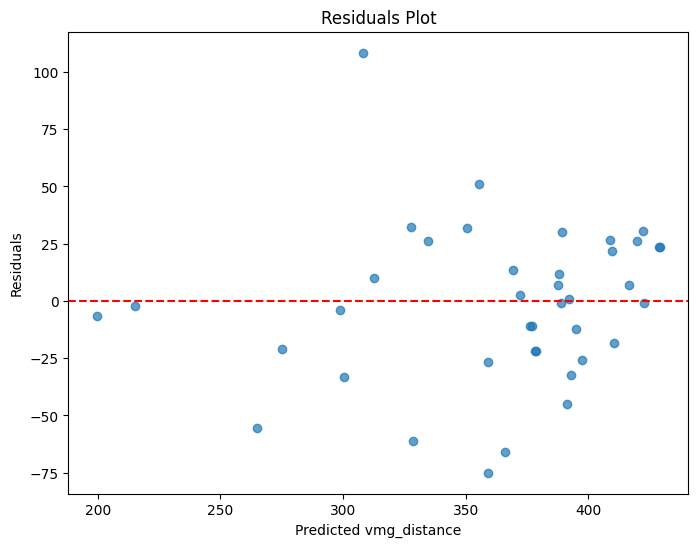

In [15]:
# Now, let's train the final model with the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test R2: {r2:.3f}")

# Plot predictions vs actual values.
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual vmg_distance")
plt.ylabel("Predicted vmg_distance")
plt.title("Predictions vs. Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Plot residuals.
plt.figure(figsize=(8,6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.7)
plt.xlabel("Predicted vmg_distance")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.axhline(0, color='r', linestyle='--')
plt.show()

The R^2 of 0.746 indicates that the model accounts for the large majority of the variance in the data. This is an ideal result, since we have dropped some of the features that are closely related to the target variable. The residuals plot shows that overall, the model is performing well, with no clear patterns in the residuals.

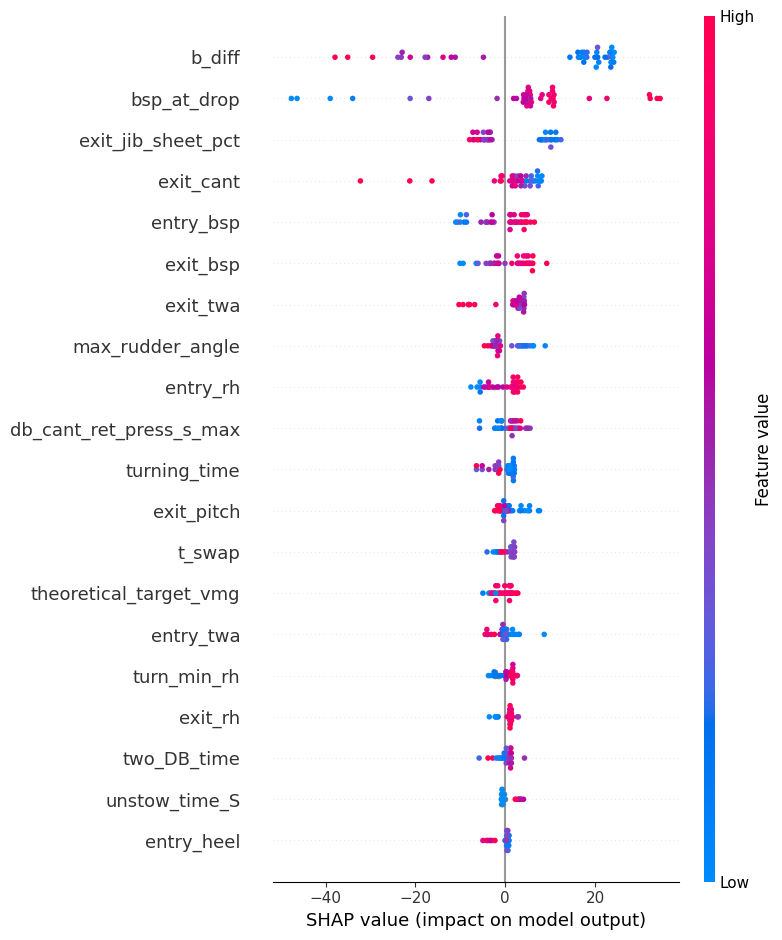

In [16]:
# SHAP values for more detailed interpretation

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)


shap.summary_plot(shap_values, X_test_scaled)

From the SHAP analysis, we can see that board diff has a significant impact on the tacking performance, along with boat speed at drop, exit jib sheet trim (interesting), exit cant, and then unsurprisingly entry and exit boat speed. I am a bit surprised to not see entry and exit boat speed higher, considering that they are strongly correlated with vmg distance. However, the model seems to have picked up on the more subtle relationships between the features and the target variable.

## Question 8: Give insights on the racing on what made a team win or underperform in the race.

Unfortunately, I did not have time to complete this question, but here is how I would approach it:
- I will break down the race into a few metrics to get a simplified view of where boats are winning or losing distance.  
These are the metrics I would consider:
- Start: Speed at gun, distance to line at gun, position at mark 1
- For each leg: Look at the difference between VMC and VMG (windward and leeward legs). If a boat has a high VMG but a relatively low VMC compared to other boats, this indicates poor strategic choices through the leg. Additionally, I would look at the number of maneuvers.
- Maneuver performance: I would look at the average vmg distance in maneuvers throughout the race to see how much the boat is losing in maneuvers.
- Speed performance: Average VMG through the legs, and the VMG at the top and bottom marks.
- The finish position will essentially be the target variable, used to evaluate the weights (importance) of each variable. My approach here would be to rank each boat in each metric (starting, strategy, speed etc for each section of the race), and use their final rank as a way to understand how important each metric is. This can then be applied as a weighting to the variables in the model.
- With the final metrics and weights, I would pick out the key insights for each boat that made them perform or lose.